# Pseudotemporal ordering

## Motivation

Single-cell sequencing assays provide high resolution measurements of biological tissues __<span style="color: red;">[CITE]</span>__. Consequently, such technologies can help decipher and understand cellular heterogeneity __<span style="color: red;">[CITE]</span>__ and the dynamics of a biological process __<span style="color: red;">[CITE]</span>__. Corresponding studies include quantifying cellular fates as well as identifying genes driving the process. However, as cells are destroyed when sequenced in classical single-cell RNA sequencing (scRNA-seq) protocols, it is impossible to track their development and, for example,  gene expression profile over time. Although recent technological advances allow recording the transcriptome sequentially __<span style="color: red;">[CITE]</span>__, they are experimentally challenging and currently fail to scale to larger dataset. Consequently, the underlying dynamic process needs to be estimated from the measured snapshot data, instead.

Even though samples are, traditionally, taken from a single experimental time point, a multitude of cell types can be observed. This diversity stems from the asynchronous nature of biological processes. As such, a range of the developmental process can be observed. Reconstructing the developmental landscape is the goal of the field coined trajectory inference (TI). This task is achieved by ordering the observed cellular states according to the developmental process. States are aligned along the developmental direction by mapping discrete annotations to a continuous domain - the so-called _pseudotime_.

Pseudotimes rank cells relative to each other according to their respective stage in the developmental process. Less mature cells are assigned small, mature cells large values. Studying a bone marrow sample for example, hematopoietic stem cells are assigned a low, and erythroid cells a high pseudotime. The assignment is, in case of single-cell RNA sequencing data, based on the transcriptomic profile of a cell. Additionally, the construction usually requires the specification of an initial, or, equivalently, root cell where the overall process starts.

## Pseudotime construction

Pseudotime construction generally follows a common workflow: As a first step, the ultra high-dimensional single-cell data is projected onto a lower dimensional representation. This procedure is justified by the observation that dynamical processes progress on a low-dimensional manifold __<span style="color: red;">[CITE]</span>__. In practice, pseudotime methods may rely on principal components (for example Palantir __<span style="color: red;">[CITE]</span>__) or diffusion components (for example diffusion pseudotime (DPT) __<span style="color: red;">[CITE]</span>__). Following, pseudotimes are constructed based on one of the following principles.

1. Observations are first clustered and, following, connections between these clusters identified. The clusters can be ordered and, thereby, a pseudotime constructed. Henceforth, we will refer to this apporoach as the _cluster approach_. Classical cluster algorithms include $k$-means __<span style="color: red;">[CITE]</span>__, Leiden __<span style="color: red;">[CITE]</span>__, or hierarchical clustering __<span style="color: red;">[CITE]</span>__. Clusters may be connected based on similarity, or by constructing a minimum spanning tree (MST) __<span style="color: red;">[CITE]</span>__.

2. The _graph approach_ first finds connections between the lower dimensional representation of the observations. This procedure defines a graph based on which clusters, and thus an ordering, are defined. *PAGA* __<span style="color: red;">[CITE]</span>__, for example, partitions the graph into Leiden clusters and estimates connections between them. Intuitively, this approach preserves the global topology of the data while analyzing it at a lower resolution. Consequently, the computational efficiency is increased.

3. *Manifold-learning based approaches* proceed similar to the *cluster approach*. However, connections between clusters are defined by using principal curves or graphs to estimate the underlying trajectories. Principal curves find a one-dimensional curve that connects cellular observations in the higher dimensional space. A notable representation of this approach is Slingshot __<span style="color: red;">[CITE]</span>__.

4. Probabilistic frameworks assign transition probabilities to ordered cell-cell pairs. Each transition probabilitiy quantifies how likely the reference cell is the ancestor of the other cell. These probabilities define random processes that are used to define a pseudotime. DPT, for example, is defined as the difference between consecutive states of a random walk. Contrastingly, Palantir __<span style="color: red;">[CITE]</span>__ models trajectories themselves as Markov chains. While both approaches rely on a probabilistic framework, they require a root cell to be specified. The pseudotime itself is computed with respect to this cell.

TI is a well-studied field providing a rich set of methods. To apply the appropriate method to analyze a single-cell dataset, the biological process itself needs to be understood first. This understanding especially includes the nature of the process, *i.e.*, if it, for example, is linear, cyclic, or branching. Similarly, orthogonal processes within one and the same dataset limits the TI methods applicable. To help identifying appropriate tools, dynguidelines __<span style="color: red;">[CITE]</span>__ provides an exhaustive overview of algorithms and their characteristics.

## Down-stream tasks __<span style="color: red;">[TODO: Better section title]</span>__

Even though TI and pseudotime can already provide valuable insight, they usually act as a stepping stone for more fine grained analysis. Identifying terminal states, for example, is a classical biological question that can be studied. Similarly, lineage bifurcation and genes driving fate decisions can be identified based on TI and pseudotime. Which question can answere and how the answer is found is usually method specific. Palantir, for example, identifies terminal states as absorbing states of its constructed Markov chain.

The success of trajectory inference is well documented and, consequently, many methods have been proposed. However, with the advances of sequencing technologies, new sources of information become available. ATAC-seq __<span style="color: red;">[CITE]</span>__, CITE-seq __<span style="color: red;">[CITE]</span>__, and DOGMA-seq __<span style="color: red;">[CITE]</span>__, for example, measure additional modalities beyond the transcriptome. Lineage tracing __<span style="color: red;">[CITE]</span>__ and metabolic labeling __<span style="color: red;">[CITE]</span>__ even provide the (likely) future state of a given cell. Consequently, future TI tools will be able to include more information to estimate trajectories and pseudotime more accuractely and robustly, and allow answering novel questions. For example, RNA velocity __<span style="color: red;">[CITE]</span>__ is one technique that uses unspliced and spliced mRNA to infer directed, dynamic information beyond classical, static snapshot data.

## Inferring pseudotime for adult human bone marrow

To show how a pseudotime can be constructed and different pseudotimes compared, we study a dataset of adult human bone marrow __<span style="color: red;">[CITE]</span>__.

### Environment setup

In [1]:
from pathlib import Path

import scanpy as sc
import scvelo as scv

### General settings

In [2]:
scv.settings.set_figure_params("scvelo")

In [3]:
DATA_DIR = Path("../../data/")
DATA_DIR.mkdir(parents=True, exist_ok=True)

FILE_NAME = DATA_DIR / "bone_marrow.h5ad"

### Data loading

In [4]:
adata = sc.read(
    filename=FILE_NAME,
    backup_url="https://figshare.com/ndownloader/files/35826944",
)
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

In [5]:
sc.pp.filter_genes(adata, min_counts=20)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

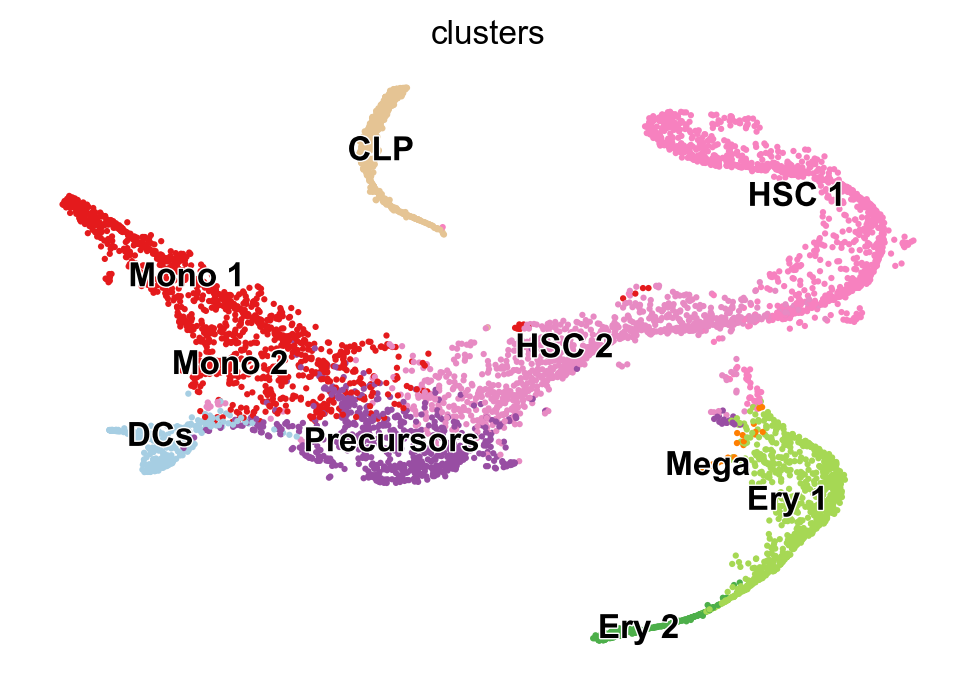

In [6]:
scv.pl.scatter(adata, basis="tsne", color="clusters")

### Pseudotime construction

To calculate diffusion pseudotime (DPT), first, the corresponding diffusion maps need to be calculated.

In [7]:
sc.tl.diffmap(adata)

The differentiation hierarchy in bone marrow is well understood. However, it is only know that the developmental process starts in the form of hematopoietic stem cells but not at which cell exactly in the corresponding cluster in our dataset. To identift a putative initial cell, we study the individual diffusion components. We identify the stem cell with the most extreme diffusion component in one dimension (in our case dimension 3).

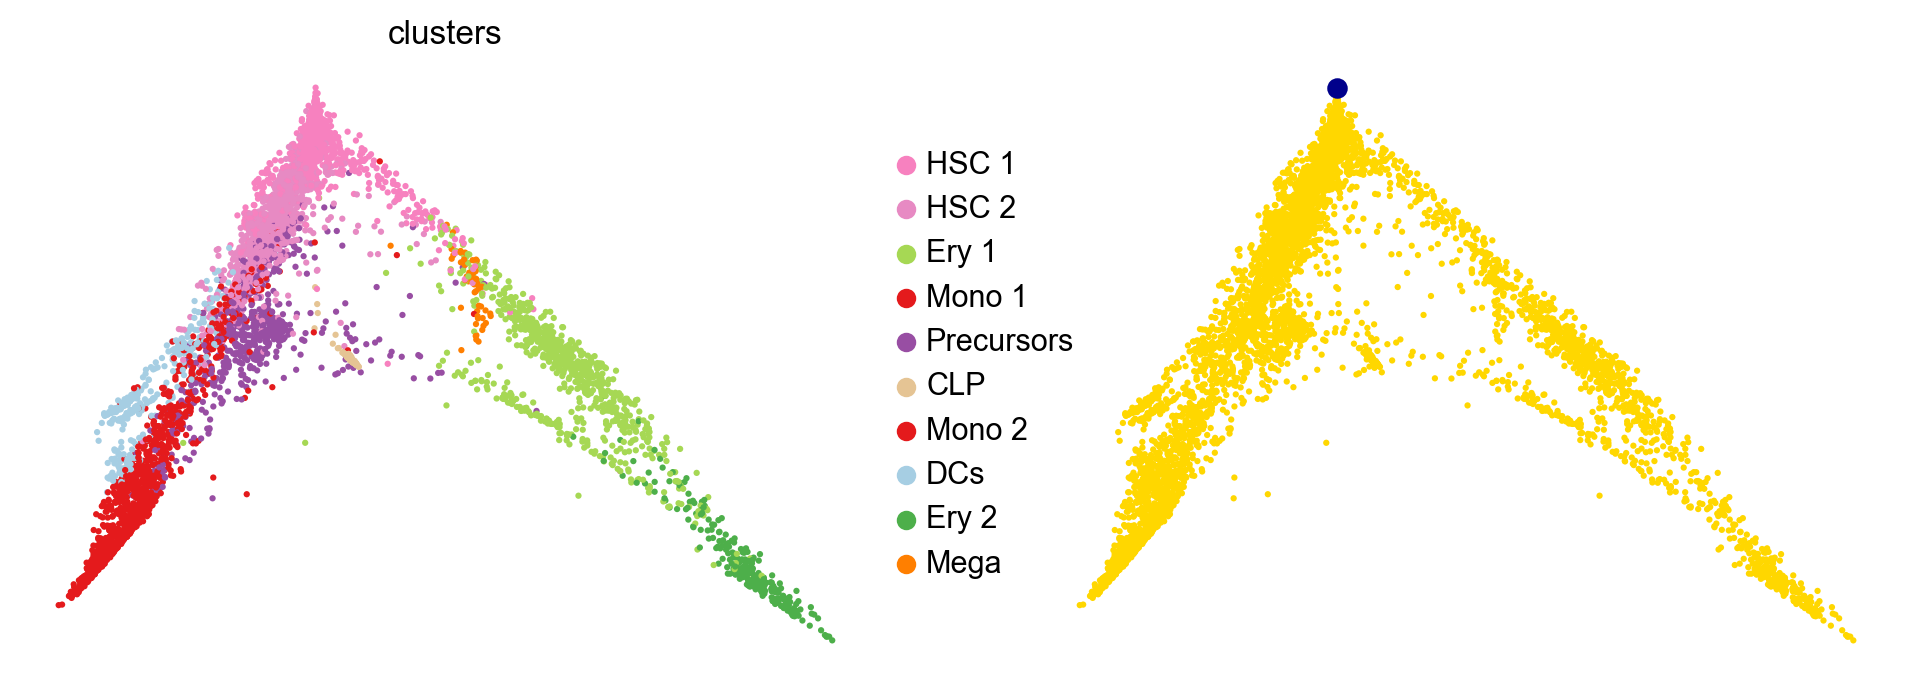

In [8]:
root_ixs = adata.obsm["X_diffmap"][:, 3].argmax()
scv.pl.scatter(
    adata,
    basis="diffmap",
    color=["clusters", root_ixs],
    legend_loc="right",
    components=["2, 3"],
)

adata.uns["iroot"] = root_ixs

In [9]:
sc.tl.dpt(adata)

Different pseudotime methods give different results. Sometimes, one pseudotime captures the underlying developmental processes more accurately. Here, we compare the just computed DPT with the pre-computed Palantir pseudotime (see [here](https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb) for the corresponding tutorial). One option to compare different pseudotimes is by coloring the low dimensional embedding of the data (here, TSNE). Here, DPT is extremly high in the cluster of CLPs compared to all other cell types. Contrastingly, the Palantir pseudotime increases continuously with developmental maturity.

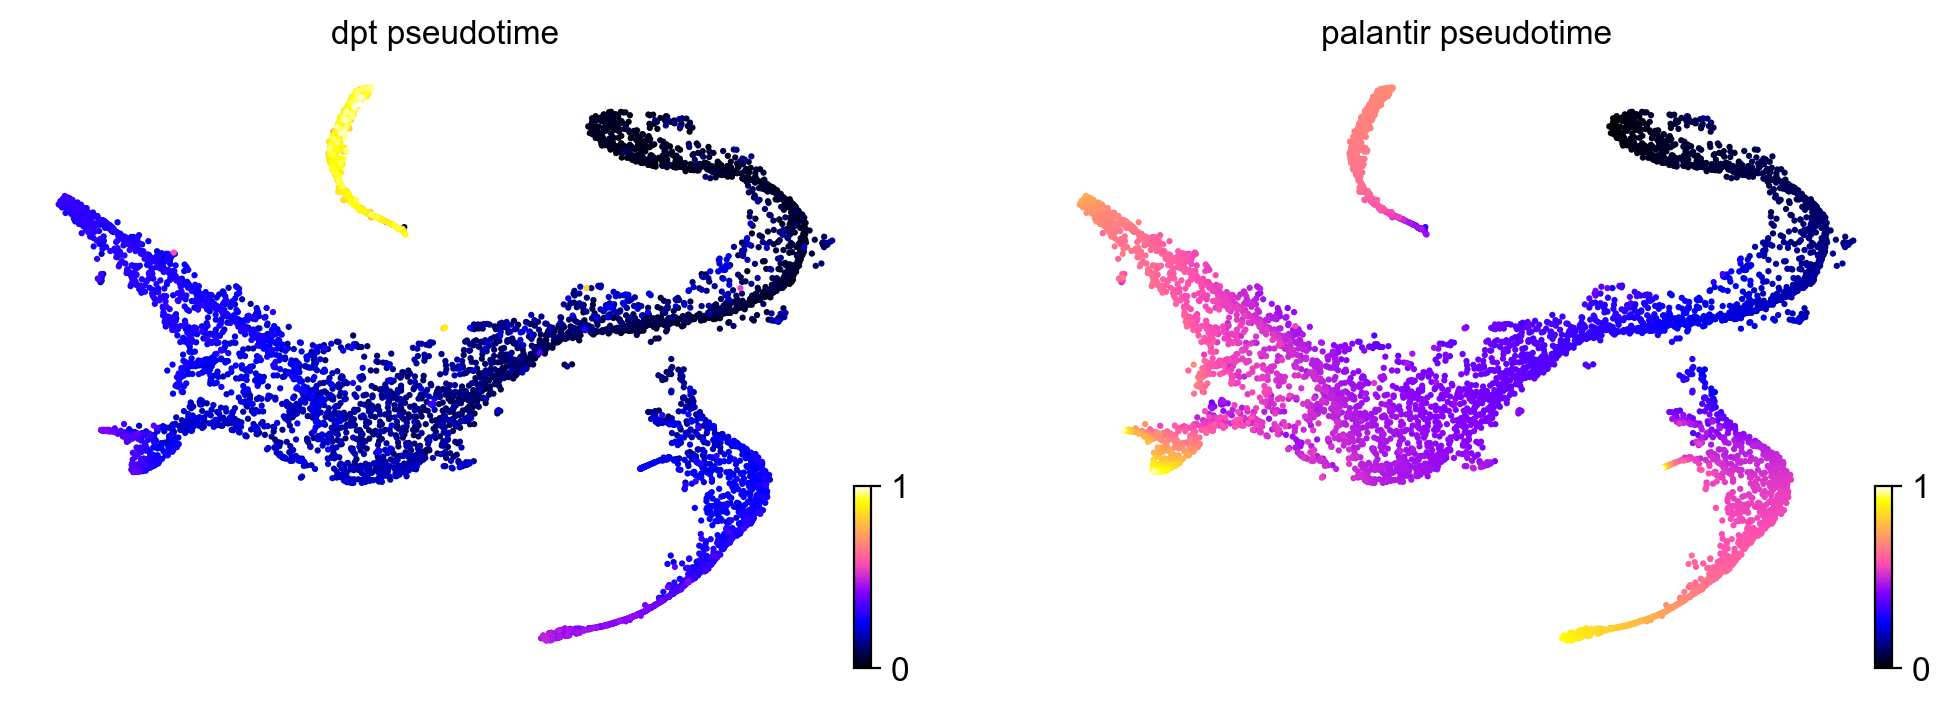

In [10]:
scv.pl.scatter(
    adata,
    basis="tsne",
    color=["dpt_pseudotime", "palantir_pseudotime"],
    color_map="gnuplot2",
)

Instead of coloring the lower dimensional representation of the data, we can study the distribution of pseudotime values assigned to each cell type cluster. This representation again shows that the CLP cluster forms an outlier in case of DPT. Additionally, clusters such as *HSC_1* and *HSC_2* include several cells with increased pseudotime. These inflated values contrast our prior biological knowledge that these clusters form the beginning of the developmental process.

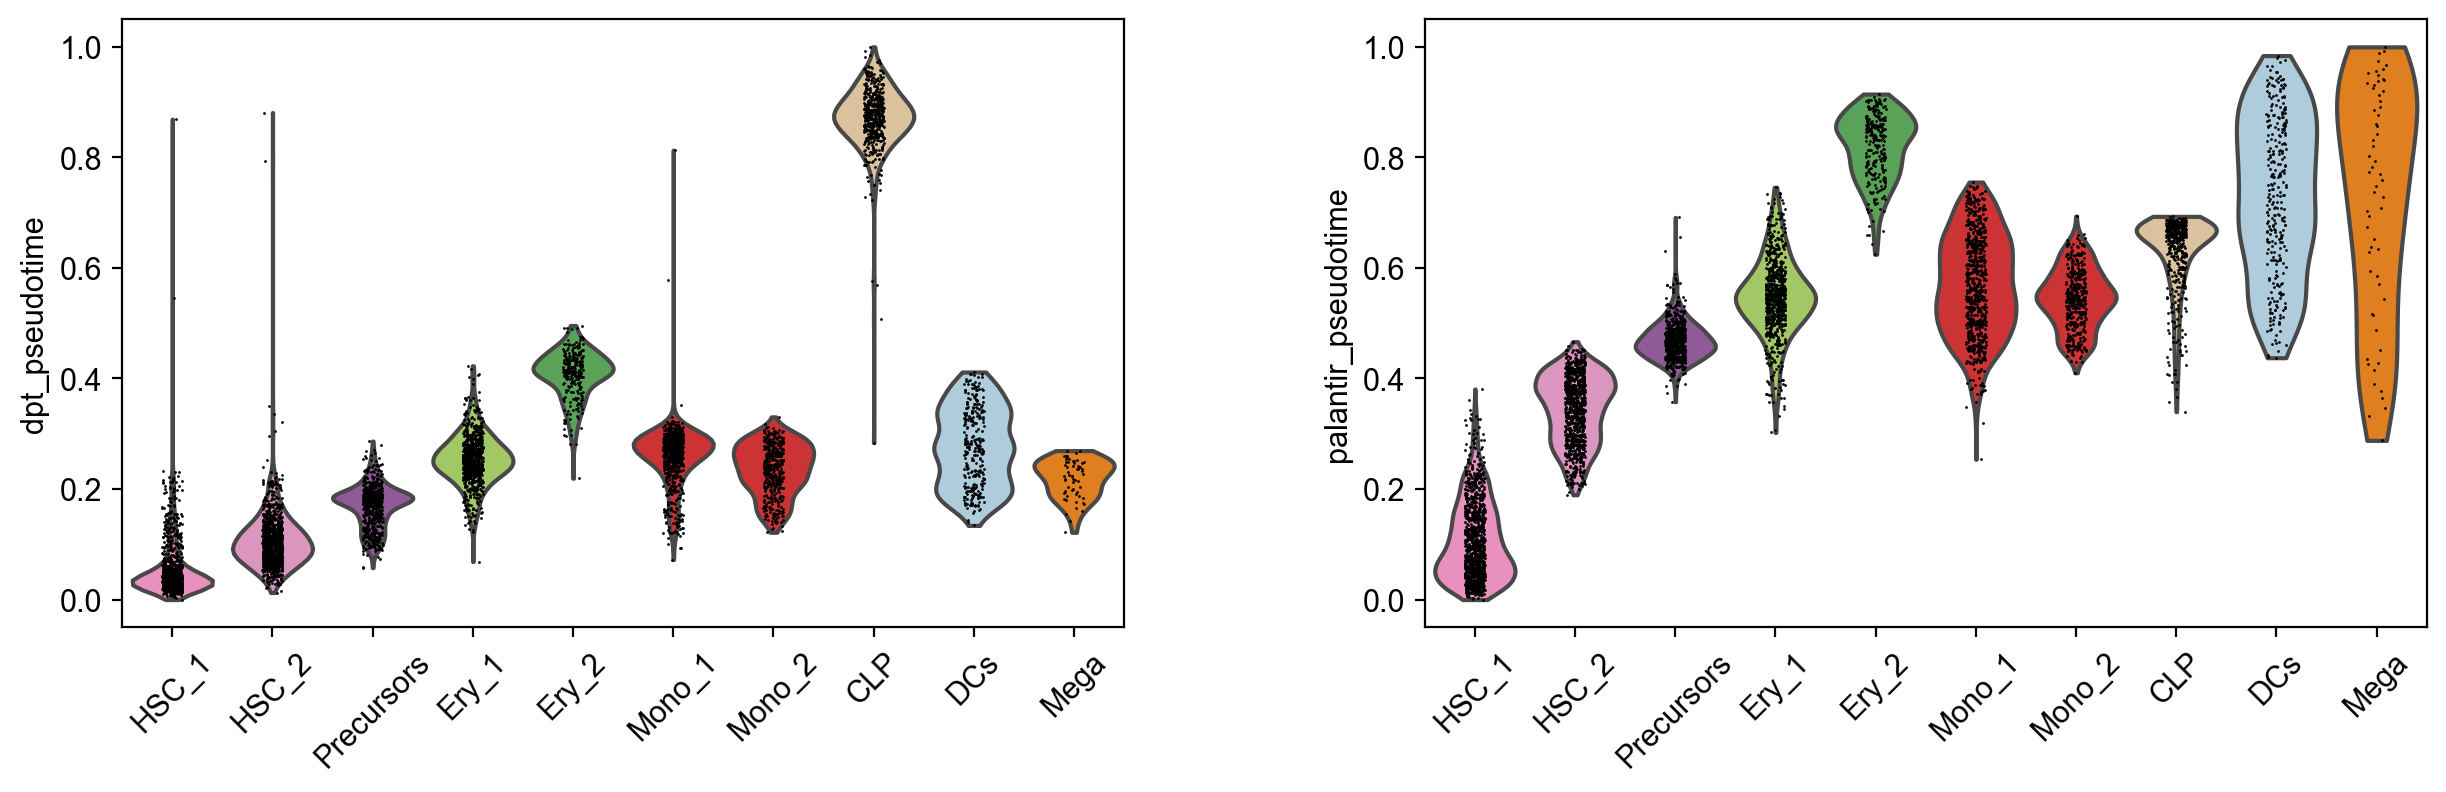

In [11]:
sc.pl.violin(
    adata,
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="clusters",
    rotation=45,
    order=[
        "HSC_1",
        "HSC_2",
        "Precursors",
        "Ery_1",
        "Ery_2",
        "Mono_1",
        "Mono_2",
        "CLP",
        "DCs",
        "Mega",
    ],
)

Considering these observations and prior knowledge about the development in bone marrow, we would conclude to continue working with the Palantir pseudotime.

## Key takeaways

* TI methods require the start of the biological process to be known (approximately).
* The nature of the biological process defines which TI algorithms can be used. dynguidelines helps selecting the appropriate TI method.

## References

```{bibliography}
:filter: docname in docnames
```